### This is a tutorial to apply our conditional activity (time-related kinetic relationship) code to your biological system. Long trajectories which captures different state transitions of the biological molecule should be used. The code is optimized to study the sidechain dihedral (𝝌1) of the amino acids in proteins and the sugar-base dihedral angle in nucleic acids (both DNA and RNA)

#### Import dependences. This code was build to use MDAnalysis to access the universe. 

In [ ]:
# import MDAnalysis as mda
# from MDAnalysis.core.universe import Universe, AtomGroup
# # from MDAnalysis.analysis.base import AnalysisBase
# import numpy as np
# from bisect import bisect, bisect_right
# import pickle
# import math
# from json import dumps, load
# from MDAnalysis.analysis.dihedrals import Dihedral
# import pandas as pd


import sys
import os
from MDAnalysis import Universe
import numpy as np

# 🧩 Add the analysis folder to path
script_dir = os.getcwd()
analysis_path = os.path.join(script_dir, "analysis")  # adjust if notebook is elsewhere
sys.path.append(os.path.normpath(analysis_path))

# 📥 Import the CONDACT class
from condact import CONDACT

##### Create the Universe

In [121]:
# 📂 Define your input files
topology_file = "../analysis/pytest_LYS.prmtop"    # Replace with your actual file
trajectory_file = "../analysis/pytest_LYS.xtc"   # Replace with your actual file

# 🧬 Create the MDAnalysis Universe
universe = Universe(topology_file, trajectory_file)


# universe = Universe("../analysis/pytest_LYS.prmtop", "../analysis/pytest_LYS.xtc")

##### Select the degree of freedom. Here we used dihedral angle as our degree of freedom. The dihedral angle for all residues were computed in the trajectory and plotted to get the number of peaks and boundary between peaks

In [117]:
# Select residues of interest based on their resid

interested = universe.select_atoms(f'resid 1-3 and not(resname ALA or resname GLY)')
residue_type = interested.residues
residue_names = list(residue_type.resnames)

Dihedra_Angles = []

for ts in universe.trajectory:
    for residue in residue_type:
        resid_key = f"{residue.resname} {residue.resid}"
        resname = residue.resname

        # Select atoms in dihedral
        N = interested.select_atoms(f"resid {residue.resid} and name N")
        CA = interested.select_atoms(f"resid {residue.resid} and name CA")
        CB = interested.select_atoms(f"resid {residue.resid} and name CB")
        CG = interested.select_atoms(f"resid {residue.resid} and (name CG or name OG1 or name CG1 or name OG or name SG)")
        
        # Compute dihedral angle including secondary angle if 𝛉 < 0
        angle = (sum([N, CA, CB, CG])).dihedral.value()
        angle = angle if angle >= 0 else angle + 360

        Dihedra_Angles.append(angle)


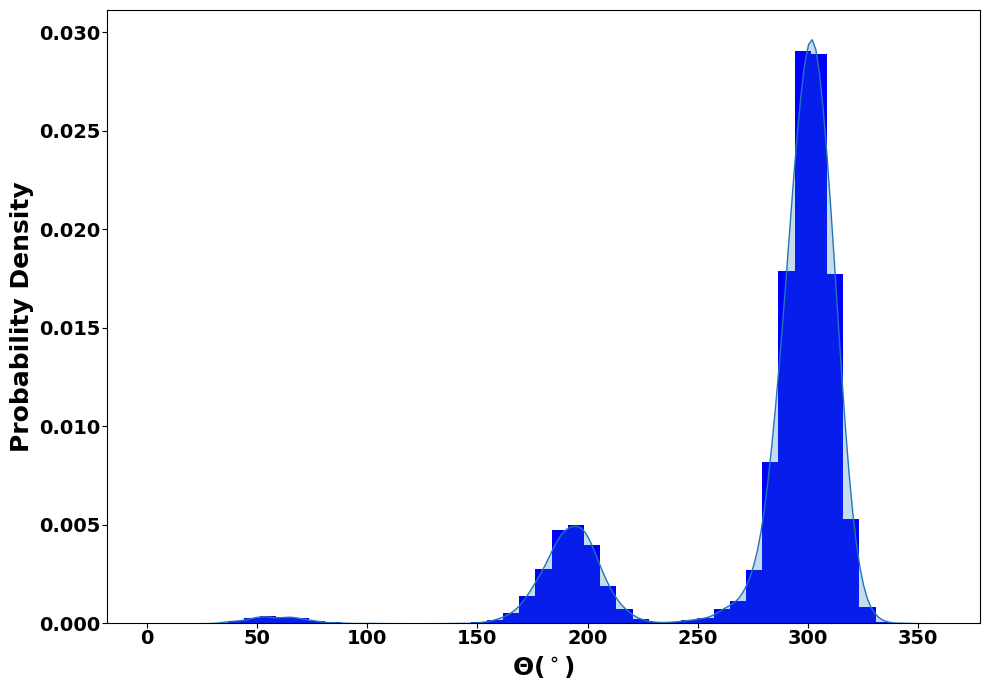

In [118]:
Dihedra_Angles = np.array(Dihedra_Angles)

# Plot the probability density curve
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 7))
bins=np.linspace(0, 360, num=50)
ax.hist(Dihedra_Angles, bins, density=True, color=['blue'])
sns.kdeplot(Dihedra_Angles, fill=True, bw_adjust=0.5)

plt.xlabel(r'$\bf{\Theta}$($^\circ$)', fontsize = 18.0, fontweight="bold")
plt.ylabel('Probability Density', fontsize = 18.0, fontweight="bold")
plt.tick_params(labelsize=14, pad=1)

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

plt.tight_layout()
plt.show()

In [123]:
# Initialize the CONDACT analysis

Study = CONDACT(universe=universe,
                selected_resid='1-3',               # Select the residues of interest eg. here 1 to 3
                No_of_peaks_protein=3,              # The number of peaks for protein is 3 
                peak_boundaries_protein=[120, 240], # Selected 120° and 240° from our probability density plot default [120,240]
                states_protein="XYZ",               # Select any letter to designate state
                No_of_peaks_nucleic=3,              # The number of peaks for nucleic. Rememeber to find number of peaks for nucleic. 
                peak_boundaries_nucleic=[140, 330], # Select the boundary between peaks for nucleic eg. default is 140° and 330°. Remember to determine peaks.
                states_nucleic="SAS",               # Select any letter to designate state
                saving_frequency=10,                # Saving frequency of trajectory in picoseconds
                keep_negative=False                 # All negative dihedral will be converted to secondary angles
            )                


In [125]:
print(universe.residues)

<ResidueGroup [<Residue GLN, 1>, <Residue ASN, 2>, <Residue ASP, 3>]>


In [120]:
# 🚀 Run the analysis
conditional_activity, persistence_times, exchange_times = Study.mean_conditional_activity()


NameError: name 'universe' is not defined

In [ ]:
# 📊 Display the Conditional Activity Matrix
import numpy as np
import pandas as pd

# Display matrix using pandas for readability
df_ca = pd.DataFrame(conditional_activity)
df_ca.style.background_gradient(cmap='hot')

In [ ]:
# ⏱️ Display Persistence Times
for k, v in persistence_times.items():
    print(f"{k}: {v:.4f}")

In [ ]:
# 🖼️ Show the heatmap if you'd like (already saved as .png during analysis)
from IPython.display import Image, display

if os.path.exists("Conditional_Activity.png"):
    display(Image("Conditional_Activity.png"))
else:
    print("Heatmap image not found.")

##### The above probability density plot shows three peaks for our sample trajecyory. The boundary between peak 1 and 2 is approximate 120° while the boundary between peak 2 and 3 is approximately 240°. From these data, one can select the parameter below for this conditional activiity analysis:
    * No_of_peaks_protein = 3,
    * peak_boundaries_protein = [120,240],
    * states_protein = "XYZ",
The three peaks were designated X, Y and Z.

In [ ]:
# main_script.py
import sys
import os

# Get absolute path to analysis_tools folder
analysis_path = os.path.abspath("../analysis")
sys.path.append(analysis_path)

from condact import CONDACT

Study = CONDACT(universe,
                selected_resid='1-3',               # Select the residues of interest eg. here 1 to 3
                No_of_peaks_protein=3,              # The number of peaks for protein is 3 
                peak_boundaries_protein=[120,240],  # Selected 120° and 240° from our probability density plot default [120,240]
                states_protein = "XYZ",             # Select any letter to designate state
                peak_boundaries_nucleic =[140,330], # Select the boundary between peaks for nucleic eg. default is 140° and 330°. Remember to determine peaks
                No_of_peaks_nucleic=3,              # The number of peaks for nucleic. Rememeber to find number of peaks for nucleic. 
                states_nucleic = "SAS",             # Select any letter to designate state
                saving_frequency=10,                # Saving frequency of trajectory in picoseconds
                keep_negative=False)                # All negative dihedral will be converted to secondary angles

conditional_activity, persistence_times, exchange_times = Study.mean_conditional_activity()

# print(conditional_activity)

NameError: name 'universe' is not defined

In [104]:
# Import required libraries
# from MDAnalysis import Universe
import sys
import os

# Get absolute path to analysis_tools folder
analysis_path = os.path.abspath("../analysis")
sys.path.append(analysis_path)

from condact import CONDACT

# from analysis.condact import CONDACT  # Adjust this import path to your project structure

# Step 1: Load your molecular system
# Replace the filenames below with your system’s topology and trajectory
topology_file = "../analysis/pytest_LYS.prmtop"        # or .psf, .gro, etc.
trajectory_file = "../analysis/pytest_LYS.xtc"       # or .dcd, .trr, etc.

universe = Universe(topology_file, trajectory_file)

# Step 2: Define your residue range of interest (must exclude ALA and GLY for protein analysis)
selected_residues = '10-20'  # example range

# Step 3: Initialize the CONDACT object
condact_analysis = CONDACT(
    universe=universe,
    selected_resid=selected_residues,
    No_of_peaks_protein=3,
    peak_boundaries_protein=[120, 240],
    states_protein="XYZ",
    No_of_peaks_nucleic=3,
    peak_boundaries_nucleic=[140, 330],
    states_nucleic="SAS",
    saving_frequency=10,  # in picoseconds
    keep_negative=False
)

# Step 4: Run the full analysis pipeline
conditional_activity, persistence_times, exchange_times = condact_analysis.mean_conditional_activity()

# Step 5: Review the results (or skip this to just use the output files)
print("\nConditional Activity Matrix:")
for row in conditional_activity:
    print(row)

print("\nPersistence Times:")
for residue, time in persistence_times.items():
    print(f"{residue}: {time:.4f}")

# Optionally print or explore exchange_times if needed

# The script will also generate:
# - Dihedral_Angle.csv
# - transition_times.pkl, wait_times.pkl
# - Conditional_Activity.txt
# - Dynamic_Memory.txt
# - Conditional_Activity.png


NameError: name 'universe' is not defined

In [105]:
# main_script.py
import sys
import os
from MDAnalysis import Universe

# Set up path to analysis tools
script_dir = os.path.dirname(os.path.abspath(__file__))
analysis_path = os.path.join(script_dir, "../analysis")
sys.path.append(os.path.normpath(analysis_path))

# Import CONDACT class
from condact import CONDACT

if __name__ == "__main__":
    # Load MDAnalysis universe
    topology_file = "your_topology.prmtop"
    trajectory_file = "your_trajectory.xtc"
    universe = Universe(topology_file, trajectory_file)

    # Initialize the analysis
    Study = CONDACT(
        universe=universe,
        selected_resid='1-3',
        No_of_peaks_protein=3,
        peak_boundaries_protein=[120, 240],
        states_protein="XYZ",
        peak_boundaries_nucleic=[140, 330],
        No_of_peaks_nucleic=3,
        states_nucleic="SAS",
        saving_frequency=10,
        keep_negative=False
    )

    # Run the analysis
    conditional_activity, persistence_times, exchange_times = Study.mean_conditional_activity()

    # Optional: print results
    print_results = True
    if print_results:
        print("\nConditional Activity Matrix:")
        for row in conditional_activity:
            print(row)

        print("\nPersistence Times:")
        for k, v in persistence_times.items():
            print(f"{k}: {v:.4f}")


NameError: name '__file__' is not defined

In [91]:
pwd

'/Users/augustineonyema/Nucleosome/Project_Codes/conditional_activity/conditional_activity/condact_tutorial'

In [4]:
with open('../analysis/Conditional_Activity_list.npy', 'rb') as f:
    contact = np.load(f, allow_pickle=True)
    print(contact)

[[ 1.08537757         nan -1.17143167]
 [        nan         nan         nan]
 [ 3.60661146         nan  1.58959137]]


In [ ]:
"""
Unit and regression test for the conditional_activity package.
"""

import sys
import os
import pytest
import pickle
from MDAnalysis import Universe
from conditional_activity.analysis.condact import CONDACT

# Assume pytest_LYS files are present in working directory
universe = Universe("pytest_LYS.prmtop", "pytest_LYS.xtc")
OUTFILE = 'Dihedral_Angle.csv'


def test_conditional_activity_imported():
    """Test that the module imports correctly."""
    assert "conditional_activity.analysis.condact" in sys.modules


def test_initialization_with_defaults():
    condact = CONDACT(universe)
    assert condact.No_of_peaks_protein == 3
    assert condact.peak_boundaries_protein == [120, 240]
    assert condact.states_protein == "XYZ"
    assert condact.No_of_peaks_nucleic == 3
    assert condact.peak_boundaries_nucleic == [140, 330]
    assert condact.states_nucleic == "SAS"
    assert condact.saving_frequency is None
    assert condact.keep_negative is False


def test_initialization_with_custom_values():
    condact = CONDACT(
        universe,
        selected_resid="1-5",
        No_of_peaks_protein=5,
        peak_boundaries_protein=[50, 150, 250, 310],
        states_protein="ABCDE",
        No_of_peaks_nucleic=4,
        peak_boundaries_nucleic=[100, 200, 300],
        states_nucleic="WXYZ",
        saving_frequency=20,
        keep_negative=True
    )
    assert condact.selected_resid == "1-5"
    assert condact.No_of_peaks_protein == 5
    assert condact.peak_boundaries_protein == [50, 150, 250, 310]
    assert condact.states_protein == "ABCDE"
    assert condact.No_of_peaks_nucleic == 4
    assert condact.peak_boundaries_nucleic == [100, 200, 300]
    assert condact.states_nucleic == "WXYZ"
    assert condact.saving_frequency == 20
    assert condact.keep_negative is True


def test_define_state_protein_and_nucleic():
    condact = CONDACT(universe)

    # protein
    assert condact.define_state_protein(10) == "X"
    assert condact.define_state_protein(130) == "Y"
    assert condact.define_state_protein(260) == "Z"
    with pytest.raises(ValueError):
        condact.define_state_protein(-1)

    # nucleic
    assert condact.define_state_nucleic(10) == "S"
    assert condact.define_state_nucleic(200) == "A"
    assert condact.define_state_nucleic(340) == "S"
    with pytest.raises(ValueError):
        condact.define_state_nucleic(-5)


def test_find_gt():
    condact = CONDACT(universe)
    arr = [0, 10, 20, 30]
    assert condact.find_gt(arr, 15) == 20
    assert condact.find_gt(arr, 29) == 30
    assert condact.find_gt(arr, 30) == 0  # no greater element
    assert condact.find_gt([], 5) == 0


def test_residues_validation_errors():
    condact = CONDACT(universe, selected_resid=None)
    with pytest.raises(ValueError, match="please select residues of interest"):
        condact.residues()

    cond = CONDACT(universe,
                   selected_resid="1-2",
                   No_of_peaks_protein=3,
                   peak_boundaries_protein=[100],  # wrong length
                   )
    with pytest.raises(ValueError, match="should have 2 numbers"):
        cond.residues()

    cond = CONDACT(universe,
                   selected_resid="1-2",
                   No_of_peaks_nucleic=3,
                   peak_boundaries_nucleic=[150],  # wrong length
                   )
    with pytest.raises(ValueError, match="should have 2 numbers"):
        cond.residues()


def test_residues_selection_excludes_ala_gly():
    condact = CONDACT(universe, selected_resid="1-5")
    ag, names, residues = condact.residues()
    assert isinstance(names, list)
    assert 'ALA' not in names
    assert 'GLY' not in names
    assert len(names) > 0
    assert len(ag) > 0


def test_run_and_output_csv(tmp_path, monkeypatch):
    # force saving_frequency to 1 to simplify numeric assert
    out = tmp_path / OUTFILE
    monkeypatch.chdir(tmp_path)

    condact = CONDACT(universe,
                     selected_resid="1-3",
                     saving_frequency=1)
    trans, waits = condact.run()

    assert isinstance(trans, dict)
    assert isinstance(waits, dict)
    assert os.path.isfile(out)

    # CSV has header + at least one data line
    lines = out.read_text().splitlines()
    assert len(lines) >= 2
    headers = lines[0].split(',')
    assert headers[0].strip() == "frame"
    assert headers[1].strip().startswith("time")

    # Check numeric angle outputs are >= 0 or "NaN"
    for line in lines[1:]:
        fields = line.split(',')[2:]
        for v in fields:
            assert v.strip() == "NaN" or float(v) >= 0


def test_mean_persistence_and_exchange_run_through(tmp_path, monkeypatch):
    # End-to-end run through mean_conditional_activity (skips GUI parts)
    monkeypatch.chdir(tmp_path)
    condact = CONDACT(universe, selected_resid="1-3", saving_frequency=1)
    ca, pers, exch = condact.mean_conditional_activity()

    assert isinstance(ca, list)
    assert isinstance(pers, dict)
    assert isinstance(exch, list)
    # ca matrix should have square shape
    n = len(pers)
    assert all(len(row) == n for row in ca)
